In [62]:
import os

import pandas as pd
import umap
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from generalized_autogluon import combine_csv

In [2]:
def inter_intra_class_var(df):
    # # Step 1: Separate data into different classes
    # class_data = {}
    # for label, group in df.groupby('Label'):
    #     print(label)
    #     class_data[label] = group.drop('Label', axis=1)

    # # Step 2: Calculate mean for each class
    # class_means = {}
    # for label, class_df in class_data.items():
    #     class_means[label] = class_df.mean()

    # # Step 3: Compute intra-class variance
    # intra_class_variance = 0
    # for label, class_df in class_data.items():
    #     deviation_squared = (class_df - class_means[label]) ** 2
    #     intra_class_variance += deviation_squared.sum()

    # # Step 4: Compute inter-class variance
    # overall_mean = df.drop('Label', axis=1).mean()
    # inter_class_variance = 0
    # for label, class_df in class_data.items():
    #     mean_difference = class_means[label] - overall_mean
    #     inter_class_variance += len(class_df) * (mean_difference ** 2).sum()

    # # Print results
    # print("Intra-class variance:\n", intra_class_variance)
    # print("Inter-class variance:\n", inter_class_variance)
    
    # Group by label and calculate mean and variance for each class
    grouped = df.groupby('Label')
    class_means = grouped.mean()
    class_variances = grouped.var()

    # Calculate overall mean and variance
    overall_mean = df.iloc[:, :-1].mean()
    overall_variance = df.iloc[:, :-1].var()

    # Calculate inter-class variance
    inter_class_variance = (class_variances * (grouped.size())).sum()

    # Calculate intra-class variance
    intra_class_variance = (grouped.size() * (class_means - overall_mean)**2).sum()

    print("Inter-Class Variance:", inter_class_variance)
    print("Intra-Class Variance:", intra_class_variance)

In [3]:
def Silhouette(df):
    # Separate features and labels
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    silhouette_avg = silhouette_score(X, y_encoded)
    print(f"Silhouette Score: {silhouette_avg}")

In [76]:
# Get the path to the CSV file
# csv_file_path = input("Enter the path to the CSV file: ")
# csv_file_path = "/storage/nate/SmartRecon/FlexHash/similar_devices_Hashes/cam_allwinner_cleaned/cam_allwinner-1_128_4_2.csv"
path_to_root_folder = "/storage/nate/SmartRecon/FlexHash/similar_devices_Hashes/"
root_device = "cam_allwinner_cleaned/"
# root_device = "light_cleaned/"
# root_device = "plug_cleaned/"

# accumulator = 1024
# window = 4
# combo = 2

accumulator = 128
window = 6
combo = 6
device_list = list(range(1, 9))

stratify_by = "Label"

csv_column_names = [f"dim{i}" for i in range(accumulator//8)]
csv_column_names.append(stratify_by)

all_files = os.listdir(path_to_root_folder+root_device)
files_to_use = []
for file in all_files:
    if f"{accumulator}_{window}_{combo}" in file:
        files_to_use.append(path_to_root_folder+root_device+file)

dataset = combine_csv(files_to_use, csv_column_names)
dataset.reset_index(drop=True, inplace=True)

 #######
# Define the sampling ratio
# sampling_ratio = 0.1
sampling_ratio = "minimum"
# sampling_ratio = "SelectMaxN"

if sampling_ratio == "minimum":
    min_count = float("inf")
    for unique_class in dataset[stratify_by].unique():
        unique_class_sample_count = dataset[dataset[stratify_by] == unique_class].shape[0]
        if unique_class_sample_count < min_count:
            min_count = unique_class_sample_count
    sample_sizes = (dataset[stratify_by].value_counts().apply(lambda x: min(x, min_count))).astype(int)
    # cams
    sample_sizes = sample_sizes // 10
    # sample_sizes = sample_sizes // 50
    # plugs
    # sample_sizes = sample_sizes // 7
    
elif sampling_ratio == "SelectMaxN":
    MaxN = 2000
    # Calculate the number of samples to take from each category
    sample_sizes = (dataset[stratify_by].value_counts().apply(lambda count: min(MaxN, count)))
else:
    # Calculate the number of samples to take from each category
    sample_sizes = (dataset[stratify_by].value_counts() * sampling_ratio).astype(int)

# Perform stratified sampling
dataset = dataset.groupby(stratify_by, group_keys=False).apply(lambda x: x.sample(sample_sizes.loc[x.name], random_state=42))
# Reset the index if desired
dataset.reset_index(drop=True, inplace=True)

device_names = dataset[stratify_by].str.split("_").str[0]
device_numbers = dataset[stratify_by].str.split("-").str[-1]
# cams
dataset[stratify_by] = device_names + '-' + device_numbers
# lights and plugs
# dataset[stratify_by] = device_names

print(f"*** Total samples in dataset: {len(dataset.index)} ***")
for device_name in sorted(dataset[stratify_by].unique()):
    num_samples = len((dataset[dataset[stratify_by] == device_name]).index)
    print(
        f"*** Samples for device: {device_name} in {accumulator}_{window}_{combo}: {num_samples} ({num_samples/dataset.shape[0]}%) ***"
    )
#######

# Extract features and labels
features = dataset.iloc[:, :-1].values
labels = dataset.iloc[:, -1].values

# inter_intra_class_var(dataset)
# Silhouette(dataset)

100%|██████████| 8/8 [00:00<00:00, 44.22it/s]


*** Total samples in dataset: 17208 ***
*** Samples for device: cam-1 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-2 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-3 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-4 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-5 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-6 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-7 in 128_6_6: 2151 (0.125%) ***
*** Samples for device: cam-8 in 128_6_6: 2151 (0.125%) ***


In [77]:
# Initialize UMAP model with 2 components for 2D representation
n_neighbors=25
min_dist=1.0
metric = "canberra"
umap_model = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)

# Transform data using UMAP
umap_result = umap_model.fit_transform(features)

In [78]:
# Create a DataFrame for the transformed data
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

umap_df["Label"] = labels
# inter_intra_class_var(umap_df)
# Silhouette(umap_df)

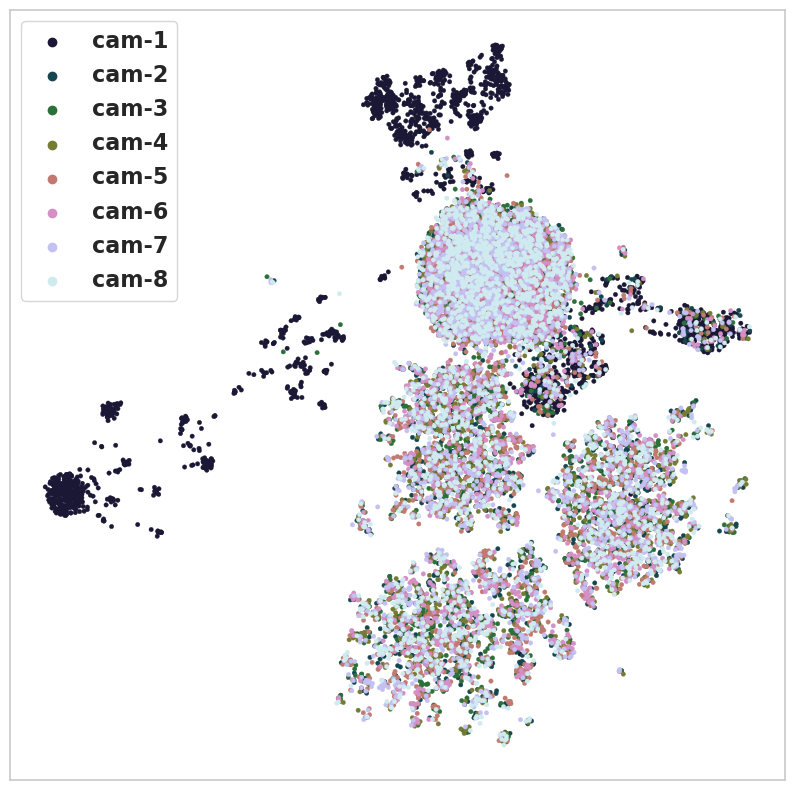

In [79]:
# Plotting
s=10

sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
# sns.set_theme()
# plt.rcParams['axes.facecolor']='darkgray'
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", palette="cubehelix", hue="Label", edgecolor=None, s=s)
# plt.title("UMAP Visualization of Dataset")
plt.rcParams.update({'font.size': 16})

font = font_manager.FontProperties(
    weight='bold',
    size=16)
plt.legend(prop=font)
# plt.legend(title="Device", fontsize=16, weight="bold")

plt.grid(False)
# plt.xlabel('UMAP 1', fontsize=20)
# plt.ylabel('UMAP 2', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
# plt.show()
plt.savefig(f"UMAP_visualizations/{root_device[:-1]}_{accumulator}_{window}_{combo}_{sampling_ratio}-{n_neighbors}-{min_dist}-{metric}-{s}.pdf")